## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Import Data

In [2]:
dataset = pd.read_excel("Prepared_Datasets/merged_VNIR_SWIR_div_light_intensity.xlsx")
target = pd.read_excel("Sugar_Quantities.xlsx")

In [3]:
dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Band_407,Band_408,Band_409,Band_410,Band_411,Band_412,Band_413,Band_414,Band_415,Band_416
0,38367,0.221308,0.199913,0.192579,0.183369,0.183325,0.182481,0.178520,0.176002,0.175304,...,0.140758,0.139250,0.137835,0.137768,0.138519,0.133785,0.135571,0.138096,0.139288,0.144988
1,38368,0.223737,0.210706,0.194744,0.187220,0.182523,0.176224,0.172397,0.171496,0.169999,...,0.109825,0.107343,0.105798,0.104451,0.100555,0.099769,0.098710,0.097514,0.101424,0.102856
2,38369,0.207885,0.199520,0.190341,0.186545,0.183247,0.181849,0.181135,0.181712,0.180998,...,0.129254,0.126762,0.126218,0.125155,0.125845,0.124069,0.122287,0.125059,0.126839,0.131405


In [4]:
target_columns = ['Barcode', 'Print_Info', 'Variety_ID', 'Variety', 'Batch', 'Sample', 'Glucose', 'Fructose', 'Sucrose', 'Raffinose',
                 'Kestose', 'Maltose', 'Nystose', 'Kestopentaose', 'Total_Fructan']
target.columns = target_columns

In [5]:
# g = sns.pairplot(target[['Glucose','Fructose','Sucrose', 'Raffinose', 'Kestose', 'Maltose', 'Nystose', 'Kestopentaose']])

In [6]:
cor2 = target.iloc[:, [7, 8, 9, 10, 11, 12, 13, 14]].corr()

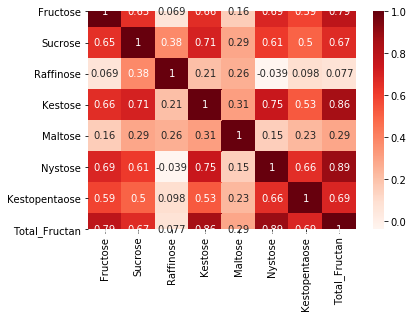

In [7]:
sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
plt.show()

### adding helper columns on target dataset

#### adding counts of varieties

In [8]:
counts = pd.value_counts(target['Variety_ID'])
counts_index = np.array([counts.index]).reshape(-1, 1)
counts_values = np.array([counts.values]).reshape(-1, 1)

In [9]:
counts_data = np.concatenate((counts_index, counts_values),axis = 1)

In [10]:
counts_df = pd.DataFrame(data = counts_data, columns = ['Variety_ID', 'Variety_counts'])

In [11]:
target = pd.merge(left = target, right = counts_df, how = 'outer', left_on = 'Variety_ID', right_on = 'Variety_ID')

In [12]:
# target.head(2)

#### adding variety number of counts

In [13]:
target.insert(loc = 16, column = "Variety_number", value = "")

In [14]:
for r in range(0, target.shape[0]):
    num = 0
    Variety_ID = target.Variety_ID[r]
    for x in range(r, target.shape[0]):
        if target.Variety_ID[x] == Variety_ID:
            num = num + 1
    target.Variety_number[r] = num

C:\Users\ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
target.head(3)

,Barcode,Print_Info,Variety_ID,Variety,Batch,Sample,Glucose,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38368.0,Cabaret-R1_L1P3,26,Cabaret,1,1,0.525990,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
1,38632.0,Cabaret-R2_L12P3,26,Cabaret,11,251,0.587680,0.594920,14.475188,5.263027,2.500238,0.577737,0.980051,0.070338,6.219160,3,2
2,38765.0,Cabaret-R3_L17P16,26,Cabaret,18,413,0.383404,0.329895,9.469324,3.742113,1.605575,0.640902,0.251107,0.015643,4.087977,3,1


### Prepare dataset with different scalings to try each and find which one works better

#### Max_min scaler, scaling dataset in the range of 0 and 1

In [16]:
scaler = MinMaxScaler()
scaled_dataset = dataset.iloc[:, 1:]
min_max_scaled_dataset = scaler.fit_transform(scaled_dataset)

In [17]:
min_max_scaled_dataset = pd.DataFrame(data = min_max_scaled_dataset)
min_max_scaled_dataset.insert(loc = 0, column = "img", value = dataset.Img_name)
min_max_scaled_dataset.columns = dataset.columns

In [18]:
min_max_scaled_dataset = pd.merge(left = min_max_scaled_dataset, right = target, how = "inner", left_on = "Img_name", right_on = "Barcode")
min_max_scaled_dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38367,0.282877,0.265487,0.263129,0.254050,0.272661,0.282649,0.299493,0.276661,0.278713,...,0.938528,11.580359,7.191522,2.508236,1.132254,0.454942,0.493446,7.451642,3,2
1,38368,0.289653,0.295116,0.269206,0.264998,0.270352,0.264309,0.280146,0.263174,0.262707,...,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
2,38369,0.245422,0.264410,0.256847,0.263081,0.272436,0.280796,0.307756,0.293754,0.295890,...,0.364791,11.247442,5.236240,2.417849,0.497984,1.378649,0.221425,8.311020,3,3


#### not scaled dataset

In [19]:
not_scaled_dataset = pd.merge(left = dataset, right = target, how = "inner", left_on = "Img_name", right_on = "Barcode")
not_scaled_dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38367,0.221308,0.199913,0.192579,0.183369,0.183325,0.182481,0.178520,0.176002,0.175304,...,0.938528,11.580359,7.191522,2.508236,1.132254,0.454942,0.493446,7.451642,3,2
1,38368,0.223737,0.210706,0.194744,0.187220,0.182523,0.176224,0.172397,0.171496,0.169999,...,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
2,38369,0.207885,0.199520,0.190341,0.186545,0.183247,0.181849,0.181135,0.181712,0.180998,...,0.364791,11.247442,5.236240,2.417849,0.497984,1.378649,0.221425,8.311020,3,3


## Datasets

### Randomly Splitting dataset

In [20]:
X_not_scaled = not_scaled_dataset.iloc[:, 1:417]
y_not_scaled = not_scaled_dataset.iloc[:, 423:432]

In [21]:
X_min_max = min_max_scaled_dataset.iloc[:, 1:417]
y_min_max = min_max_scaled_dataset.iloc[:, 423:432]

In [77]:
# ************************** no scaled training and test split based on varieties ***************************

X_train_not_scaled, X_test_not_scaled, y_train_not_scaled, y_test_not_scaled = train_test_split(X_not_scaled, y_not_scaled, test_size=0.25)

# *************************** min max training and test split based on varieties ****************************

# X_train_min_max, X_test_min_max, y_train_min_max, y_test_min_max = train_test_split(X_min_max, y_min_max, test_size=0.25)

# Algorithms

## Lasso

In [78]:
target.columns

Index(['Barcode', 'Print_Info', 'Variety_ID', 'Variety', 'Batch', 'Sample',
       'Glucose', 'Fructose', 'Sucrose', 'Raffinose', 'Kestose', 'Maltose',
       'Nystose', 'Kestopentaose', 'Total_Fructan', 'Variety_counts',
       'Variety_number'],
      dtype='object')

In [79]:
y_train_not_scaled_Glucose = y_train_not_scaled.Glucose
y_train_not_scaled_Fructose = y_train_not_scaled.Fructose
y_train_not_scaled_Sucrose = y_train_not_scaled.Sucrose
y_train_not_scaled_Raffinose = y_train_not_scaled.Raffinose
y_train_not_scaled_Kestose = y_train_not_scaled.Kestose
y_train_not_scaled_Maltose = y_train_not_scaled.Maltose
y_train_not_scaled_Nystose = y_train_not_scaled.Nystose
y_train_not_scaled_Kestopentaose = y_train_not_scaled.Kestopentaose
y_train_not_scaled_Total_Fructan = y_train_not_scaled.Total_Fructan

y_test_not_scaled_Glucose = y_test_not_scaled.Glucose
y_test_not_scaled_Fructose = y_test_not_scaled.Fructose
y_test_not_scaled_Sucrose = y_test_not_scaled.Sucrose
y_test_not_scaled_Raffinose = y_test_not_scaled.Raffinose
y_test_not_scaled_Kestose = y_test_not_scaled.Kestose
y_test_not_scaled_Maltose = y_test_not_scaled.Maltose
y_test_not_scaled_Nystose = y_test_not_scaled.Nystose
y_test_not_scaled_Kestopentaose = y_test_not_scaled.Kestopentaose
y_test_not_scaled_Total_Fructan = y_test_not_scaled.Total_Fructan

In [80]:
lasso_not_scaled_Glucose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Fructose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Sucrose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Raffinose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Kestose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Maltose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Nystose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Kestopentaose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Total_Fructan = linear_model.Lasso(max_iter=100000, tol=0.001)

In [81]:
lasso_not_scaled_Glucose.fit(X_train_not_scaled, y_train_not_scaled_Glucose)
lasso_not_scaled_Fructose.fit(X_train_not_scaled, y_train_not_scaled_Fructose)
lasso_not_scaled_Sucrose.fit(X_train_not_scaled, y_train_not_scaled_Sucrose)
lasso_not_scaled_Raffinose.fit(X_train_not_scaled, y_train_not_scaled_Raffinose)
lasso_not_scaled_Kestose.fit(X_train_not_scaled, y_train_not_scaled_Kestose)
lasso_not_scaled_Maltose.fit(X_train_not_scaled, y_train_not_scaled_Maltose)
lasso_not_scaled_Nystose.fit(X_train_not_scaled, y_train_not_scaled_Nystose)
lasso_not_scaled_Kestopentaose.fit(X_train_not_scaled, y_train_not_scaled_Kestopentaose)
lasso_not_scaled_Total_Fructan.fit(X_train_not_scaled, y_train_not_scaled_Total_Fructan)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.001, warm_start=False)

In [82]:
prediction_not_scaled_Glucose = lasso_not_scaled_Glucose.predict(X_test_not_scaled)
prediction_not_scaled_Fructose = lasso_not_scaled_Fructose.predict(X_test_not_scaled)
prediction_not_scaled_Sucrose = lasso_not_scaled_Sucrose.predict(X_test_not_scaled)
prediction_not_scaled_Raffinose = lasso_not_scaled_Raffinose.predict(X_test_not_scaled)
prediction_not_scaled_Kestose = lasso_not_scaled_Kestose.predict(X_test_not_scaled)
prediction_not_scaled_Maltose = lasso_not_scaled_Maltose.predict(X_test_not_scaled)
prediction_not_scaled_Nystose = lasso_not_scaled_Nystose.predict(X_test_not_scaled)
prediction_not_scaled_Kestopentaose = lasso_not_scaled_Kestopentaose.predict(X_test_not_scaled)
prediction_not_scaled_Total_Fructan = lasso_not_scaled_Total_Fructan.predict(X_test_not_scaled)

In [83]:
variance_not_scaled_Glucose = lasso_not_scaled_Glucose.score(X_test_not_scaled, y_test_not_scaled_Glucose)
variance_not_scaled_Fructose = lasso_not_scaled_Fructose.score(X_test_not_scaled, y_test_not_scaled_Fructose)
variance_not_scaled_Sucrose = lasso_not_scaled_Sucrose.score(X_test_not_scaled, y_test_not_scaled_Sucrose)
variance_not_scaled_Raffinose = lasso_not_scaled_Raffinose.score(X_test_not_scaled, y_test_not_scaled_Raffinose)
variance_not_scaled_Kestose = lasso_not_scaled_Kestose.score(X_test_not_scaled, y_test_not_scaled_Kestose)
variance_not_scaled_Maltose = lasso_not_scaled_Maltose.score(X_test_not_scaled, y_test_not_scaled_Maltose)
variance_not_scaled_Nystose = lasso_not_scaled_Nystose.score(X_test_not_scaled, y_test_not_scaled_Nystose)
variance_not_scaled_Kestopentaose = lasso_not_scaled_Kestopentaose.score(X_test_not_scaled, y_test_not_scaled_Kestopentaose)
variance_not_scaled_Total_Fructan = lasso_not_scaled_Total_Fructan.score(X_test_not_scaled, y_test_not_scaled_Total_Fructan)

In [84]:
print(variance_not_scaled_Glucose)
print(variance_not_scaled_Fructose)
print(variance_not_scaled_Sucrose)
print(variance_not_scaled_Raffinose)
print(variance_not_scaled_Kestose)
print(variance_not_scaled_Maltose)
print(variance_not_scaled_Nystose)
print(variance_not_scaled_Kestopentaose)
print(variance_not_scaled_Total_Fructan)

-0.0007544894171169769
-0.0008345609964843792
-0.004012398345485391
-0.0032291497053766887
-0.0020344416414439515
-0.004370433104037064
-0.0025030500637988062
-7.879356860307496e-07
-0.0001267127592579076


In [85]:
# r2_score_min_max_Glucose = r2_score(y_test_min_max_Glucose, prediction_min_max_Glucose)
# r2_score_min_max_Fructose = r2_score(y_test_min_max_Fructose, prediction_min_max_Fructose)
# r2_score_min_max_Sucrose = r2_score(y_test_min_max_Sucrose, prediction_min_max_Sucrose)
# r2_score_min_max_Raffinose = r2_score(y_test_min_max_Raffinose, prediction_min_max_Raffinose)
# r2_score_min_max_Kestose = r2_score(y_test_min_max_Kestose, prediction_min_max_Kestose)
# r2_score_min_max_Maltose = r2_score(y_test_min_max_Maltose, prediction_min_max_Maltose)
# r2_score_min_max_Nystose = r2_score(y_test_min_max_Nystose, prediction_min_max_Nystose)
# r2_score_min_max_Kestopentaose = r2_score(y_test_min_max_Kestopentaose, prediction_min_max_Kestopentaose)
# r2_score_min_max_Total_Fructan = r2_score(y_test_min_max_Total_Fructan, prediction_min_max_Total_Fructan)

In [86]:
# print(r2_score_min_max_Glucose)
# print(r2_score_min_max_Fructose)
# print(r2_score_min_max_Sucrose)
# print(r2_score_min_max_Raffinose)
# print(r2_score_min_max_Kestose)
# print(r2_score_min_max_Maltose)
# print(r2_score_min_max_Nystose)
# print(r2_score_min_max_Kestopentaose)
# print(r2_score_min_max_Total_Fructan)

In [87]:
mean_absolute_error_not_scaled_Glucose = mean_absolute_error(y_test_not_scaled_Glucose, prediction_not_scaled_Glucose)
mean_absolute_error_not_scaled_Fructose = mean_absolute_error(y_test_not_scaled_Fructose, prediction_not_scaled_Fructose)
mean_absolute_error_not_scaled_Sucrose = mean_absolute_error(y_test_not_scaled_Sucrose, prediction_not_scaled_Sucrose)
mean_absolute_error_not_scaled_Raffinose = mean_absolute_error(y_test_not_scaled_Raffinose, prediction_not_scaled_Raffinose)
mean_absolute_error_not_scaled_Kestose = mean_absolute_error(y_test_not_scaled_Kestose, prediction_not_scaled_Kestose)
mean_absolute_error_not_scaled_Maltose = mean_absolute_error(y_test_not_scaled_Maltose, prediction_not_scaled_Maltose)
mean_absolute_error_not_scaled_Nystose = mean_absolute_error(y_test_not_scaled_Nystose, prediction_not_scaled_Nystose)
mean_absolute_error_not_scaled_Kestopentaose = mean_absolute_error(y_test_not_scaled_Kestopentaose, prediction_not_scaled_Kestopentaose)
mean_absolute_error_not_scaled_Total_Fructan = mean_absolute_error(y_test_not_scaled_Total_Fructan, prediction_not_scaled_Total_Fructan)

In [88]:
print(mean_absolute_error_not_scaled_Glucose)
print(mean_absolute_error_not_scaled_Fructose)
print(mean_absolute_error_not_scaled_Sucrose)
print(mean_absolute_error_not_scaled_Raffinose)
print(mean_absolute_error_not_scaled_Kestose)
print(mean_absolute_error_not_scaled_Maltose)
print(mean_absolute_error_not_scaled_Nystose)
print(mean_absolute_error_not_scaled_Kestopentaose)
print(mean_absolute_error_not_scaled_Total_Fructan)

0.25482857647221263
0.30605944884256203
1.983320743968856
0.9585411935626048
0.6792404437221491
0.2142474738699098
0.6830740570460063
0.2019233277035033
3.2909320544843186


In [89]:
y_test_not_scaled_Glucose = y_test_not_scaled.Glucose
y_test_not_scaled_Fructose = y_test_not_scaled.Fructose
y_test_not_scaled_Sucrose = y_test_not_scaled.Sucrose
y_test_not_scaled_Raffinose = y_test_not_scaled.Raffinose
y_test_not_scaled_Kestose = y_test_not_scaled.Kestose
y_test_not_scaled_Maltose = y_test_not_scaled.Maltose
y_test_not_scaled_Nystose = y_test_not_scaled.Nystose
y_test_not_scaled_Kestopentaose = y_test_not_scaled.Kestopentaose
y_test_not_scaled_Total_Fructan = y_test_not_scaled.Total_Fructan

In [90]:
mean_squared_error_Glucose = mean_squared_error(y_test_not_scaled_Glucose, prediction_not_scaled_Glucose)
mean_squared_error_Fructose = mean_squared_error(y_test_not_scaled_Fructose, prediction_not_scaled_Fructose)
mean_squared_error_Sucrose = mean_squared_error(y_test_not_scaled_Sucrose, prediction_not_scaled_Sucrose)
mean_squared_error_Raffinose = mean_squared_error(y_test_not_scaled_Raffinose, prediction_not_scaled_Raffinose)
mean_squared_error_Kestose = mean_squared_error(y_test_not_scaled_Kestose, prediction_not_scaled_Kestose)
mean_squared_error_Maltose = mean_squared_error(y_test_not_scaled_Maltose, prediction_not_scaled_Maltose)
mean_squared_error_Nystose = mean_squared_error(y_test_not_scaled_Nystose, prediction_not_scaled_Nystose)
mean_squared_error_Kestopentaose = mean_squared_error(y_test_not_scaled_Kestopentaose, prediction_not_scaled_Kestopentaose)
mean_squared_error_Total_Fructan = mean_squared_error(y_test_not_scaled_Total_Fructan, prediction_not_scaled_Total_Fructan)

In [91]:
print(mean_squared_error_Glucose)
print(mean_squared_error_Fructose)
print(mean_squared_error_Sucrose)
print(mean_squared_error_Raffinose)
print(mean_squared_error_Kestose)
print(mean_squared_error_Maltose)
print(mean_squared_error_Nystose)
print(mean_squared_error_Kestopentaose)
print(mean_squared_error_Total_Fructan)

0.11080370383477199
0.1682565132202683
6.167466680154914
1.4813804060819777
0.7706175340800209
0.08927710843363063
0.7092352195658107
0.078347657290637
19.749746286009458


##### visualization

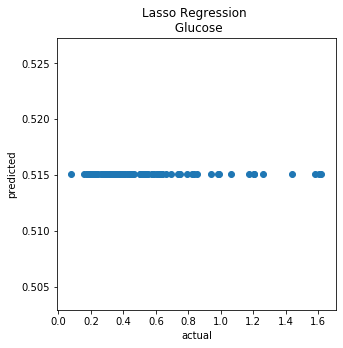

In [37]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Glucose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Glucose, prediction_not_scaled_Glucose)

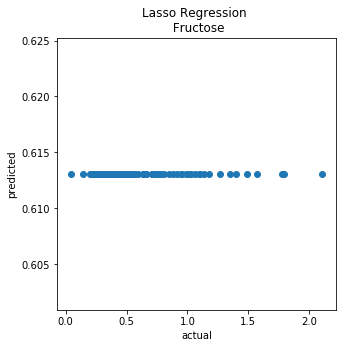

In [38]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Fructose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Fructose, prediction_not_scaled_Fructose)

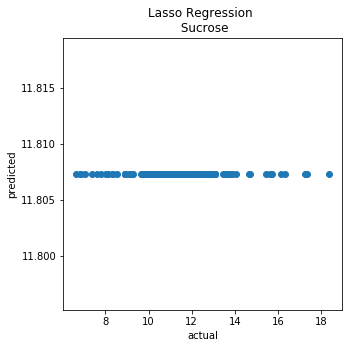

In [39]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Sucrose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Sucrose, prediction_not_scaled_Sucrose)

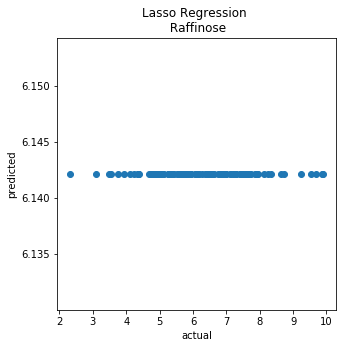

In [40]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Raffinose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Raffinose, prediction_not_scaled_Raffinose)

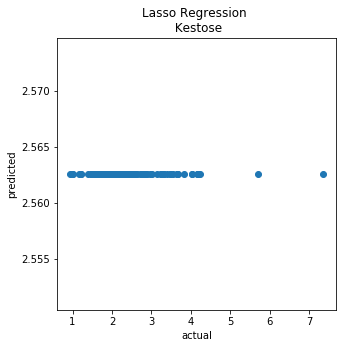

In [41]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Kestose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Kestose, prediction_not_scaled_Kestose)

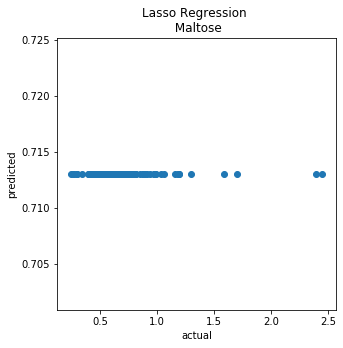

In [42]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Maltose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Maltose, prediction_not_scaled_Maltose)

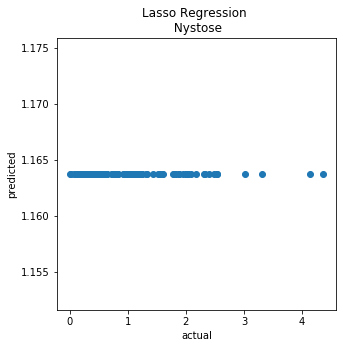

In [43]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Nystose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Nystose, prediction_not_scaled_Nystose)

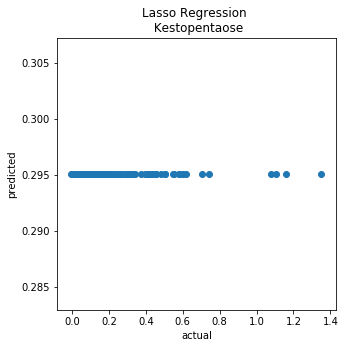

In [44]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Kestopentaose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Kestopentaose, prediction_not_scaled_Kestopentaose)

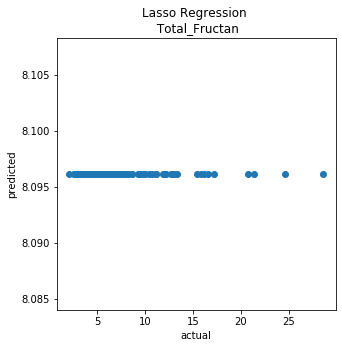

In [45]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Total_Fructan")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Total_Fructan, prediction_not_scaled_Total_Fructan)

In [46]:
# slope = elasticNet.coef_
# slope.max()

In [47]:
# intercept = elasticNet.intercept_
# print(intercept)